In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import Counter
from collections import OrderedDict

# Whole process

In [2]:
for contrast_dur in ['0.1']:
    for i in range(1,8):
        for j in range(i+1,8):
            powerset = str(i)+'_'+str(j)

            # Number of segments
            segs = 20

            # Length of contrast
        #     contrast_dur = '.01'

        #     powerset = '14'

#             wide_df = pd.read_csv('stimuli-'+contrast_dur+'contrast/stimuli-i-'+contrast_dur+'-'+powerset+'/output-'+str(segs)+'.txt', sep = '\t')

            wide_df = pd.read_csv('taq-op45/test-op45-'+powerset+'/output.txt', sep = '\t')
   
            # Split filename into multiple columns
            wide_df = wide_df.join(wide_df['Filename'].str.split('_', expand=True).rename(columns={0:'word', 1:'F1', 2:'f0', 3:'OQ', 4:'VOT'}))

            # Get duration
            wide_df['duration'] = wide_df['seg_End'] - wide_df['seg_Start']

            # Reorder columns
            col_names = list(wide_df.columns[:-6])

            col_names = ['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'] + col_names

            wide_df = wide_df[col_names]

            # Fix values in columns
            # First fix speaker by removing everything other than sp number
            # wide_df['sp'] = wide_df['sp'].apply(lambda s: int(s[-2:]))

            # # Now fix VOT by removing .mat extension
            wide_df['VOT'] = wide_df['VOT'].apply(lambda s:s.split('.')[0])

            # # Drop seg_start and seg_end
            wide_df = wide_df.drop(columns=['seg_Start', 'seg_End', 'Filename'])

            ###
            # WIDE TO LONG
            ###

            # Concatenate 
            col_a = wide_df.iloc[: , :6]
            col_f0 = wide_df.loc[:, ['pF0_means' + "{:03}".format(i+1) for i in range(segs)] ]
            col_F1 = wide_df.loc[:, ['pF1_means' + "{:03}".format(i+1) for i in range(segs)] ]
            col_F2 = wide_df.loc[:, ['pF2_means' + "{:03}".format(i+1) for i in range(segs)] ]
            col_F3 = wide_df.loc[:, ['pF3_means' + "{:03}".format(i+1) for i in range(segs)] ]
            col_H1H2c = wide_df.loc[:, ['H1H2c_means' + "{:03}".format(i+1) for i in range(segs)] ]
            col_H1A1c = wide_df.loc[:, ['H1A1c_means' + "{:03}".format(i+1) for i in range(segs)] ]
            col_H1A3c = wide_df.loc[:, ['H1A3c_means' + "{:03}".format(i+1) for i in range(segs)] ]
            col_CPP = wide_df.loc[:, ['CPP_means' + "{:03}".format(i+1) for i in range(segs)] ]

            df_f0 = pd.concat([col_a, col_f0], axis=1)
            df_F1 = pd.concat([col_a, col_F1], axis=1)
            df_F2 = pd.concat([col_a, col_F2], axis=1)
            df_F3 = pd.concat([col_a, col_F3], axis=1)
            df_H1H2c = pd.concat([col_a, col_H1H2c], axis=1)
            df_H1A1c = pd.concat([col_a, col_H1A1c], axis=1)
            df_H1A3c = pd.concat([col_a, col_H1A3c], axis=1)
            df_CPP = pd.concat([col_a, col_CPP], axis=1)

            # Now transform into long dataset
            long_df_f0 = pd.melt(df_f0, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF0_means')
            long_df_F1 = pd.melt(df_F1, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF1_means')
            long_df_F2 = pd.melt(df_F2, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF2_means')
            long_df_F3 = pd.melt(df_F3, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF3_means')
            long_df_H1H2c = pd.melt(df_H1H2c, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='H1H2c_means')
            long_df_H1A1c = pd.melt(df_H1A1c, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='H1A1c_means')
            long_df_H1A3c = pd.melt(df_H1A3c, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='H1A3c_means')
            long_df_CPP = pd.melt(df_CPP, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='CPP_means')

            long_df = pd.concat([long_df_f0, 
                                 long_df_F1.iloc[:, 7], 
                                 long_df_F2.iloc[:, 7], 
                                 long_df_F3.iloc[:, 7], 
                                 long_df_H1H2c.iloc[:, 7], 
                                 long_df_H1A1c.iloc[:, 7], 
                                 long_df_H1A3c.iloc[:, 7], 
                                 long_df_CPP.iloc[:, 7]], axis = 1)

            # # TURN LAST THREE DIGITS INTO INTEGER
            long_df['timepoint'] = pd.to_numeric(long_df["timepoint"].str[-3:])

            ###
            # VISUALIZE
            ###

            # f0
            plt.figure()

            sns.lineplot(x = 'timepoint', y = 'pF0_means', hue = 'f0', palette=["r", "b", "g", "y"], data = long_df).set_title('f0 values for stimuli of contrast length: ' + contrast_dur + ', power1: ' + powerset.split('_')[0] + ', power2: ' + powerset.split('_')[1])

            plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-f0.pdf')

            # F1
            plt.figure()

            sns.lineplot(x = 'timepoint', y = 'pF1_means', hue = 'F1', palette=["r", "b", "g"], data = long_df).set_title('F1 values for stimuli of contrast length: ' + contrast_dur + ', power1: ' + powerset.split('_')[0] + ', power2: ' + powerset.split('_')[1])

            plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-F1.pdf')

            for measure in ['pF2', 'pF3', 'H1H2c', 'H1A1c', 'H1A3c', 'CPP']:
                plt.figure()

                sns.lineplot(x = 'timepoint', y = measure+'_means', hue = 'OQ', palette=["r", "b", "g"], data = long_df).set_title(measure.replace('p', '') + ' values for stimuli of contrast length: ' + contrast_dur + ', power1: ' + powerset.split('_')[0] + ', power2: ' + powerset.split('_')[1])

                plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-' + measure.replace('p', '') + '-avg.pdf')
                
#                 g = sns.FacetGrid(data = long_df, col = 'f0', row = 'F1')
#                 g.map(sns.lineplot, "timepoint", measure + "_means", "OQ", palette=["r", "b", "g"])

#                 plt.subplots_adjust(top=0.92)
#                 g.fig.suptitle(measure.replace('p', '') + ' values for stimuli of contrast length: ' + contrast_dur + ', power1: ' + powerset.split('_')[0] + ', power2: ' + powerset.split('_')[1])

#                 plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-' + measure.replace('p', '') + '.pdf')

FileNotFoundError: [Errno 2] File b'taq-op45/test-op45-1_2/output.txt' does not exist: b'taq-op45/test-op45-1_2/output.txt'

# Individual file

# Read in data

In [2]:
# Number of segments
segs = 20

# Length of contrast
#contrast_dur = '0.15'

syll = 'taq'
# time = '20'
asp = '10'
powerset = '1_10'

f0_steps = 5
if f0_steps == 2:
    colors = ['r', 'g']
elif f0_steps == 5:
    colors = ['r', 'g', 'b', 'y', 'orange']

# wide_df = pd.read_csv('tests/'+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'_f1-900-start-800/output.txt', sep = '\t')

# wide_df = pd.read_csv('tests_new/stimuli_new/calculate/'+syll+'_measure/'+powerset+'/output.txt', sep = '\t')

wide_df = pd.read_csv(syll+'/output.txt', sep = '\t')
#results_folder = 'tests_new/'+syll+'-'+powerset+'/'
#results_folder = 'tests_new/stimuli_new/calculate/'+syll+'_measure/results/'

results_folder = syll+'/'

#wide_df = pd.read_csv('tii-0.3/'+powerset+'/output.txt', sep = '\t')

# Split filename into multiple columns
wide_df = wide_df.join(wide_df['Filename'].str.split('_', expand=True).rename(columns={0:'word', 1:'F1', 2:'f0', 3:'OQ', 4:'VOT'}))

# Get duration
wide_df['duration'] = wide_df['seg_End'] - wide_df['seg_Start']

# Reorder columns
col_names = list(wide_df.columns[:-9])

col_names = ['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'] + col_names

wide_df = wide_df[col_names]

# Fix values in columns

# # Now fix VOT by removing .mat extension
wide_df['VOT'] = wide_df['VOT'].apply(lambda s:s.split('.')[0])

# # Drop seg_start and seg_end
wide_df = wide_df.drop(columns=['seg_Start', 'seg_End', 'Filename'])

FileNotFoundError: [Errno 2] File final/stimuli/taq/output.txt does not exist: 'final/stimuli/taq/output.txt'

# Wide to Long

In [3]:
# Concatenate 
col_a = wide_df.iloc[: , :6]
col_f0 = wide_df.loc[:, ['pF0_means' + "{:03}".format(i+1) for i in range(segs)] ]
col_F1 = wide_df.loc[:, ['pF1_means' + "{:03}".format(i+1) for i in range(segs)] ]
col_F2 = wide_df.loc[:, ['pF2_means' + "{:03}".format(i+1) for i in range(segs)] ]
col_F3 = wide_df.loc[:, ['pF3_means' + "{:03}".format(i+1) for i in range(segs)] ]
col_H1H2c = wide_df.loc[:, ['H1H2c_means' + "{:03}".format(i+1) for i in range(segs)] ]
col_H1A1c = wide_df.loc[:, ['H1A1c_means' + "{:03}".format(i+1) for i in range(segs)] ]
col_H1A3c = wide_df.loc[:, ['H1A3c_means' + "{:03}".format(i+1) for i in range(segs)] ]
col_CPP = wide_df.loc[:, ['CPP_means' + "{:03}".format(i+1) for i in range(segs)] ]

df_f0 = pd.concat([col_a, col_f0], axis=1)
df_F1 = pd.concat([col_a, col_F1], axis=1)
df_F2 = pd.concat([col_a, col_F2], axis=1)
df_F3 = pd.concat([col_a, col_F3], axis=1)
df_H1H2c = pd.concat([col_a, col_H1H2c], axis=1)
df_H1A1c = pd.concat([col_a, col_H1A1c], axis=1)
df_H1A3c = pd.concat([col_a, col_H1A3c], axis=1)
df_CPP = pd.concat([col_a, col_CPP], axis=1)

# Now transform into long dataset
long_df_f0 = pd.melt(df_f0, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF0_means')
long_df_F1 = pd.melt(df_F1, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF1_means')
long_df_F2 = pd.melt(df_F2, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF2_means')
long_df_F3 = pd.melt(df_F3, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='pF3_means')
long_df_H1H2c = pd.melt(df_H1H2c, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='H1H2c_means')
long_df_H1A1c = pd.melt(df_H1A1c, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='H1A1c_means')
long_df_H1A3c = pd.melt(df_H1A3c, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='H1A3c_means')
long_df_CPP = pd.melt(df_CPP, id_vars=['word', 'F1', 'f0', 'OQ', 'VOT', 'duration'], var_name='timepoint', value_name='CPP_means')

long_df = pd.concat([long_df_f0, 
                     long_df_F1.iloc[:, 7], 
                     long_df_F2.iloc[:, 7], 
                     long_df_F3.iloc[:, 7], 
                     long_df_H1H2c.iloc[:, 7], 
                     long_df_H1A1c.iloc[:, 7], 
                     long_df_H1A3c.iloc[:, 7], 
                     long_df_CPP.iloc[:, 7]], axis = 1)

# # TURN LAST THREE DIGITS INTO INTEGER
long_df['timepoint'] = pd.to_numeric(long_df["timepoint"].str[-3:])

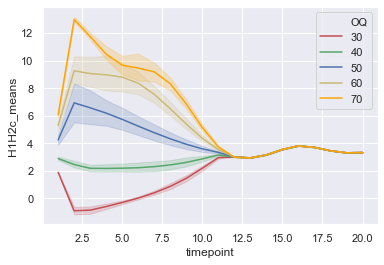

In [4]:
sns.lineplot(x = 'timepoint', y = 'H1H2c_means', hue = 'OQ', palette=colors, data = long_df)#.loc[long_df['OQ'] != '50'])

#plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-' + 'H1H2c' + '.pdf')
plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'H1H2c'+'.pdf')

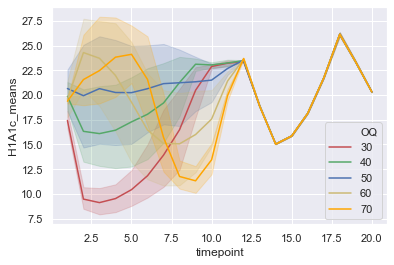

In [5]:
sns.lineplot(x = 'timepoint', y = 'H1A1c_means', hue = 'OQ', palette=colors, data = long_df)

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'H1A1c'+'.pdf')

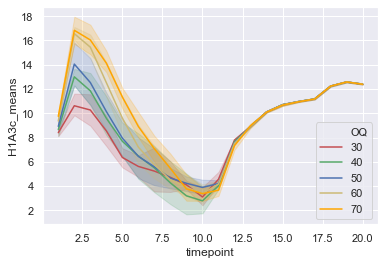

In [322]:
sns.lineplot(x = 'timepoint', y = 'H1A3c_means', hue = 'OQ', palette=colors, data = long_df)

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'H1A3c'+'.pdf')

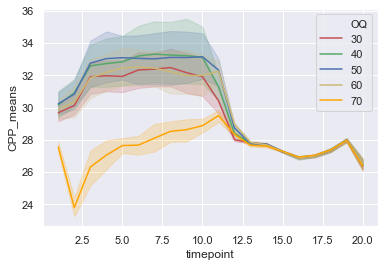

In [323]:
sns.lineplot(x = 'timepoint', y = 'CPP_means', hue = 'OQ', palette=colors, data=long_df)#, "b", "y", "orange"], data = long_df)#.loc[long_df['OQ'] != '50'])

#plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-' + 'CPP' + '.pdf')
plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'CPP'+'.pdf')

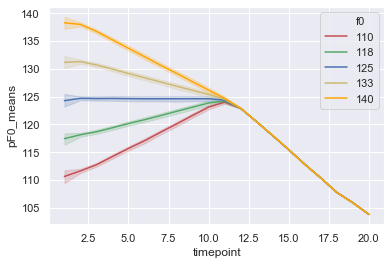

In [324]:
sns.lineplot(x = 'timepoint', y = 'pF0_means', hue = 'f0', palette=colors, data = long_df)#, "b" "y", "orange"], data = long_df)

#plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-f0.pdf')
plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'f0'+'.pdf')

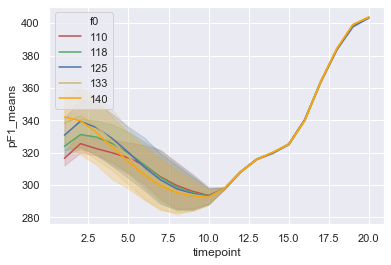

In [325]:
sns.lineplot(x = 'timepoint', y = 'pF1_means', hue = 'f0', palette=colors, data = long_df)#, "b", "y", "orange"], data = long_df)

#plt.savefig('contrast' + contrast_dur + '-stimuli' + powerset + '-F1.pdf')
plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'F1'+'.pdf')

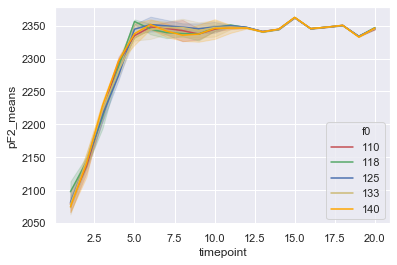

In [326]:
sns.lineplot(x = 'timepoint', y = 'pF2_means', hue = 'f0', palette=colors, data = long_df)# "b", "y", "orange"], data = long_df)

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'F2'+'.pdf')

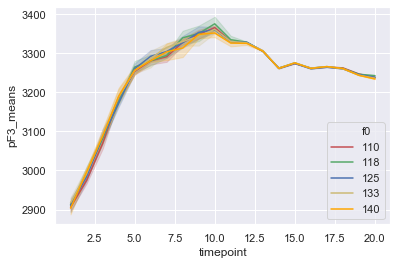

In [327]:
sns.lineplot(x = 'timepoint', y = 'pF3_means', hue = 'f0', palette=colors, data = long_df)#, "y", "orange"], data = long_df)

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset+'-'+'F3'+'.pdf')

### Visualize

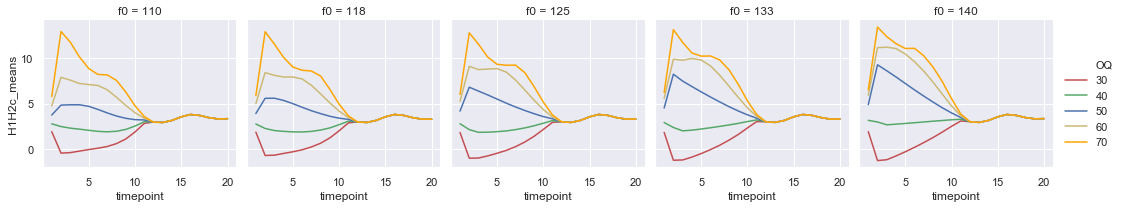

In [5]:
g = sns.FacetGrid(data = long_df, col = 'f0')
g.map(sns.lineplot, "timepoint", 'H1H2c' + "_means", "OQ", palette=["r", "g", "b", "y", "orange"])
g.add_legend()

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+ powerset + '-H1H2c-split.pdf')

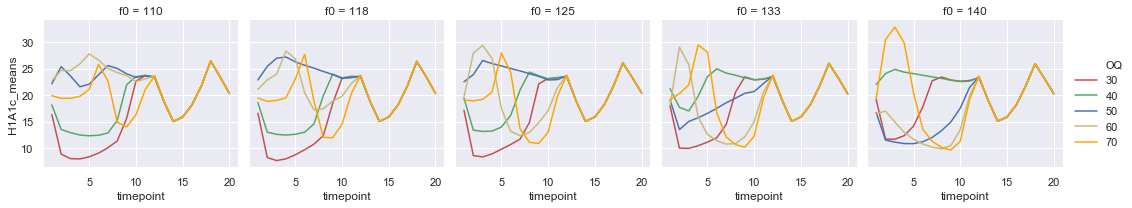

In [7]:
g = sns.FacetGrid(data = long_df, col = 'f0')

g.map(sns.lineplot, "timepoint", 'H1A1c' + "_means", "OQ", palette=["r", "g", "b", "y", "orange"])
g.add_legend()

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-' + powerset + '-H1A1c-split.pdf')

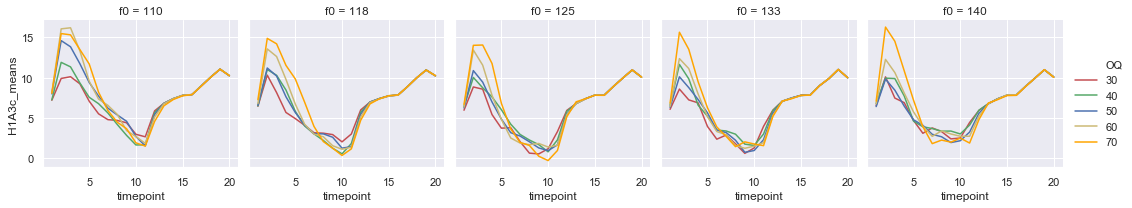

In [8]:
g = sns.FacetGrid(data = long_df, col = 'f0')
g.map(sns.lineplot, "timepoint", 'H1A3c' + "_means", "OQ", palette=["r", "g", "b", "y", "orange"])
g.add_legend()

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+ powerset + '-H1A3c-split.pdf')

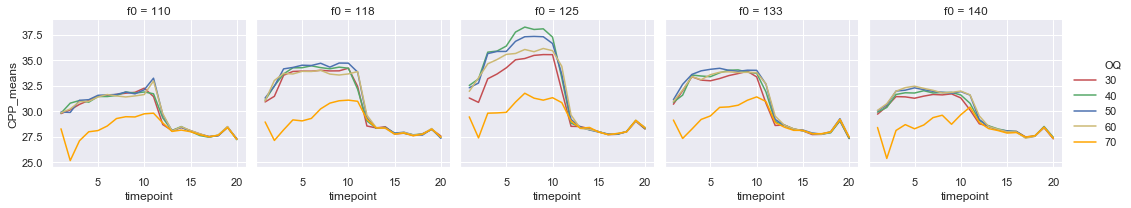

In [9]:
g = sns.FacetGrid(data = long_df, col = 'f0')
g.map(sns.lineplot, "timepoint", 'CPP' + "_means", "OQ", palette=["r", "g", "b", "y", "orange"])
g.add_legend()

plt.savefig(results_folder+syll+'-'+time+'ms-asp'+asp+'-'+powerset + '-CPP-split.pdf')